In [1]:
import os

from tqdm import tqdm
`
import torch
from torch import nn
from torch.nn import functional as F

import matplotlib
import matplotlib.pyplot as plt

SyntaxError: invalid syntax (<ipython-input-1-87d736e98b06>, line 4)

In [ ]:
# plt.style.use('dark_background')

matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams['savefig.dpi'] = 600
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

from IPython.core.display import HTML
HTML("""
<style>
.jp-RenderedImage {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# X = torch.tensor([
#     [1, 0],
#     [0, 1],
#     [0, 1],
#     [1, 0],
#     [0, 1],
# ], dtype=torch.float32, device=device)

# Y = torch.tensor([
#     [1, 0, 0],
#     [0, 1, 0],
#     [0, 0, 1],
#     [0, 0, 1],
#     [1, 0, 0],
# ], dtype=torch.float32, device=device)

In [ ]:
X_indices = torch.randint(0, 2, (1000,))
X = F.one_hot(X_indices, num_classes=2)
Y = torch.full((len(X), 3), float('nan'))
Y[0] = torch.tensor([1, 0, 0])
for i in range(1, len(X)):
    if torch.argmax(X[i]) == 0:
        Y[i] = Y[i-1]
    elif torch.argmax(X[i]) == 1:
        a = (torch.argmax(Y[i-1]) + 1) % 3
        Y[i] = F.one_hot(a, num_classes=3)

X = X.type(torch.float32).to(device)
Y = Y.type(torch.float32).to(device)
X.shape, Y.shape

In [ ]:
X_val = torch.tensor([
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0],
    [1, 0],
    [1, 0],
    [0, 1],
    [1, 0],
    [1, 0],
    [1, 0],
    [1, 0],
    [0, 1],
    [1, 0],
], dtype=torch.float32, device=device)

Y_val = torch.tensor([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1],
    [1, 0, 0],
    [0, 1, 0],
    [0, 1, 0],
    [0, 1, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1],
    [0, 0, 1],
    [0, 0, 1],
    [0, 0, 1],
    [1, 0, 0],
    [1, 0, 0],
], dtype=torch.float32, device=device)

In [ ]:
X_test = torch.tensor([
    [1, 0],
    [1, 0],
    [1, 0],
    [1, 0],
    [1, 0],
], dtype=torch.float32, device=device)

Y_test = torch.tensor([
    [0, 0, 1],
    [0, 0, 1],
    [0, 0, 1],
    [0, 0, 1],
    [0, 0, 1],
], dtype=torch.float32, device=device)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(RNN, self).__init__()
        
        self.output_size = output_size
        
        self.weather_layer = nn.Linear(input_size, output_size, bias=False)
        self.food_layer = nn.Linear(output_size, output_size, bias=False)
    
    def forward(self, weather, food):
        o1 = self.weather_layer(weather)
        o2 = self.food_layer(food)
        out = o1 + o2
        return out

In [ ]:
class RNNWeather(nn.Module):
    def __init__(self, input_size, output_size):
        super(RNNWeather, self).__init__()
        
        self.output_size = output_size
        
        self.weather_layer = nn.Linear(input_size, input_size * output_size, bias=False)
        self.food_layer = nn.Linear(output_size, input_size * output_size, bias=False)
        self.output_layer = nn.Linear(input_size * output_size, output_size, bias=False)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, weather, food):
        o1 = self.weather_layer(weather)
        o2 = self.food_layer(food)
#         out = self.output_layer(o1 + o2)
        
        o_add = o1 + o2
        
        o_nonlinear = self.softmax(o_add)
#         print("o_nonlinear", o_nonlinear)
        
        out = torch.zeros_like(food)
        for i in range(len(o_nonlinear)):
            o_halves = torch.split(o_nonlinear[i], int(len(o_nonlinear[i])/2), dim=0)
            o_merge = torch.vstack(o_halves).T
            o_merge = torch.sum(o_merge, axis=1)
            out[i] = o_merge
#         print("out", out)
        return out

In [ ]:
# rnn = RNN(input_size=2, output_size=3).to(device)
rnn = RNNWeather(input_size=2, output_size=3).to(device)

In [ ]:
def get_input(x):
    inputs = ("sunny", "rainy")
    return inputs[torch.argmax(x)]

def get_class(o):
    classes = ("pie", "burger", "chicken")
    if torch.max(o) == 0:
        return "nothing"
    return classes[torch.argmax(o)]

In [ ]:
optimizer = torch.optim.SGD(rnn.parameters(), 1e-2)

In [ ]:
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()

In [ ]:
print(list(rnn.parameters()))

In [ ]:
def predict(model, X):
    O = torch.full((len(X), model.output_size), float('nan'))
    for i in range(len(X)):
        x = X[i:i+1]

        if i - 1 < 0:
            y_prev = torch.zeros((len(x), model.output_size), dtype=torch.float32, device=device)
        else:
            y_prev = o.clone().detach()

        O[i] = o = rnn(x, y_prev)
    O_argmax = torch.argmax(O, axis=1)
    return O, O_argmax

In [ ]:
O = torch.full_like(Y, float('nan'))
losses = []
val_losses = []
for epoch in tqdm(range(300)):
    epoch_loss = 0
    for i in range(0, len(X)):
        rnn.train()
        x = X[i:i+1]
        y = Y[i:i+1]

        if i - 1 < 0:
            y_prev = torch.zeros_like(y, dtype=torch.float32)
        else:
            y_prev = o.clone().detach()

        optimizer.zero_grad()
        O[i] = o = rnn(x, y_prev)
        loss = criterion(o, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.clone().detach().cpu()
    losses.append(epoch_loss / len(X))
    
    Y_val_pred, _ = predict(rnn, X_val)
    val_loss = criterion(Y_val_pred.to(device), Y_val.to(device))
    val_losses.append(val_loss.detach().cpu().numpy())
    
    Y_pred = torch.argmax(O, axis=1)
    Y_true = torch.argmax(Y, axis=1)
    if torch.all(Y_pred == Y_true):
        print(f'END @ epoch {epoch}')
        break
print(list(rnn.parameters()))
print("-" * 30)

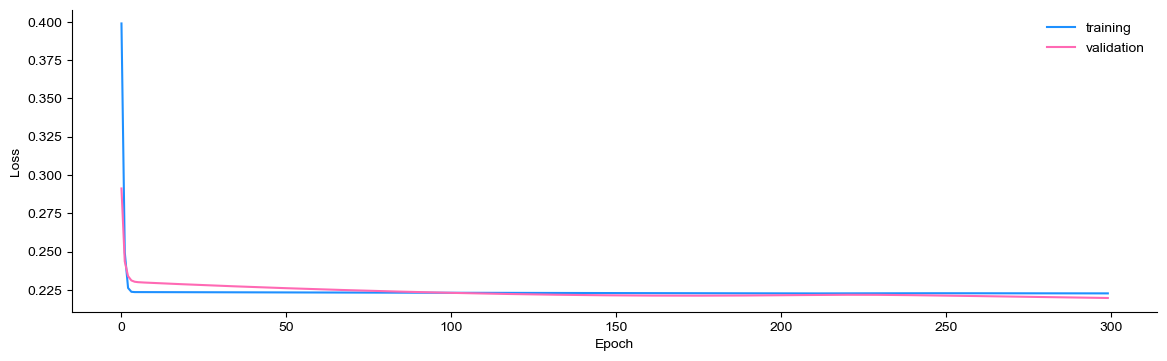

In [18]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(losses, '-', markersize=3, label='training', color='dodgerblue')
ax.plot(val_losses, '-', markersize=3, label='validation', color='hotpink')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

for direction in ('top', 'right'):
    ax.spines[direction].set_visible(False)
ax.legend(frameon=False)

In [19]:
print(list(rnn.parameters()))

[Parameter containing:
tensor([[0.2403, 0.2900],
        [0.2313, 0.2044],
        [0.3058, 0.2855]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[-0.3551,  0.1043,  0.3685],
        [ 0.0376, -0.3743,  0.7459],
        [ 0.1405,  0.4098, -0.4198]], device='cuda:0', requires_grad=True)]


In [20]:
def save_figure(fig, name):
    directory = 'reports'
    if not os.path.exists(directory):
        os.makedirs(directory)
    path = os.path.join(directory, f'{name}.pdf')
    fig.savefig(path, bbox_inches='tight')

In [21]:
def visualize_weather(X, Y, O):
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    fig, ax = plt.subplots(figsize=(12, 3), nrows=2, gridspec_kw={ 'height_ratios': [3, 1]})

    ax[0].plot(Y.cpu(), '-^', color='red', label="actual", alpha=0.4)
    ax[0].plot(O.cpu(), '-.s', color='blue', label="predicted", alpha=0.4)
    ax[0].set_xticks(torch.arange(len(O)))
    ax[0].set_ylabel('Food')
    foods = ['pie', 'burger', 'chicken']
    food_values = torch.arange(len(foods))
    ax[0].set_yticks(food_values)
    ax[0].set_yticklabels(foods)
    ax[0].legend(frameon=False)
    # ax[0].add_artist(
    #     AnnotationBbox(
    #         OffsetImage(food_images[0]),
    #         (1, 1),
    #         frameon=False,
    #     ) 
    # )

    ax[1].plot(torch.argmax(X, axis=1).cpu(), '-o', color='black')
    ax[1].set_xticks(torch.arange(len(X)))
    ax[1].set_xlabel('Time step')
    ax[1].set_ylabel('Weather')
    weathers = ['sunny', 'rainy']
    weather_values = torch.arange(len(weathers))
    ax[1].set_yticks(weather_values)
    ax[1].set_yticklabels(weathers)
    ax[1].set_ylim(-0.15, 1.15)
    ax[1].legend(frameon=False)

    return fig

No handles with labels found to put in legend.


pred tensor([2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1])
true tensor([0, 1, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0])


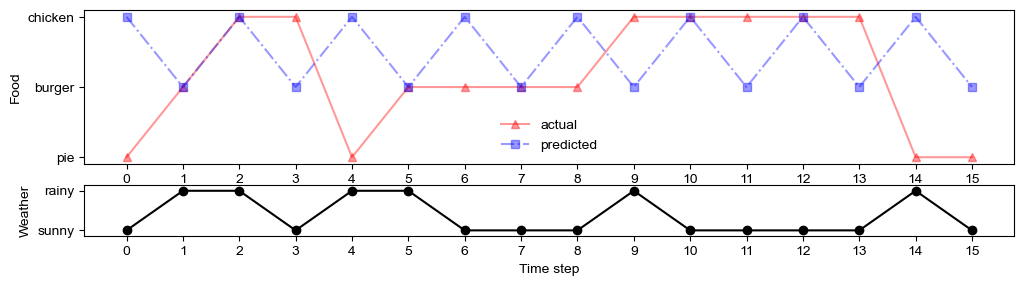

In [22]:
Y_val_pred, Y_val_argmax = predict(rnn, X_val)
print('pred', Y_val_argmax)
print('true', torch.argmax(Y_val, dim=1).cpu())
fig = visualize_weather(X_val, torch.argmax(Y_val, dim=1), Y_val_argmax)
save_figure(fig, name='fit-weather')

In [23]:
a = 0.1*torch.normal(0, 1, size=(10, 1))
a.shape

torch.Size([10, 1])

In [24]:
def create_regression_dataset(num):
    X = torch.linspace(-10, 10, steps=num)
    a = 0.1*X*torch.cos(X) + 0.1 * torch.normal(0, 1, size=X.shape)
    Y = 0.1*X*torch.cos(X) + 0.1*torch.normal(0, 1, size=X.shape)
    return X[:, None], Y[:, None]

In [25]:
X_train, Y_train = create_regression_dataset(num=900)
X_test, Y_test = create_regression_dataset(num=100)
N = X_train.shape[0]
C = 1
D = len(X_train[0])

In [26]:
X_train.shape, Y_train.shape

(torch.Size([900, 1]), torch.Size([900, 1]))

In [27]:
def plot_regression(X, Y):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    sample_color = "tab:cyan"
    cmap = 'cool'
    markers = ['o', 's']
    import matplotlib.colors as mcolors
    names = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS) + ["deepskyblue", "crimson", "darkviolet", "orangered"]

    ax.scatter(X, Y, c=sample_color, marker='o', linewidth=1, edgecolor="black", label="$x$")
    
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    
#     ax.set_aspect(1)

#     ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=9)
    
    plt.tight_layout()
    return fig

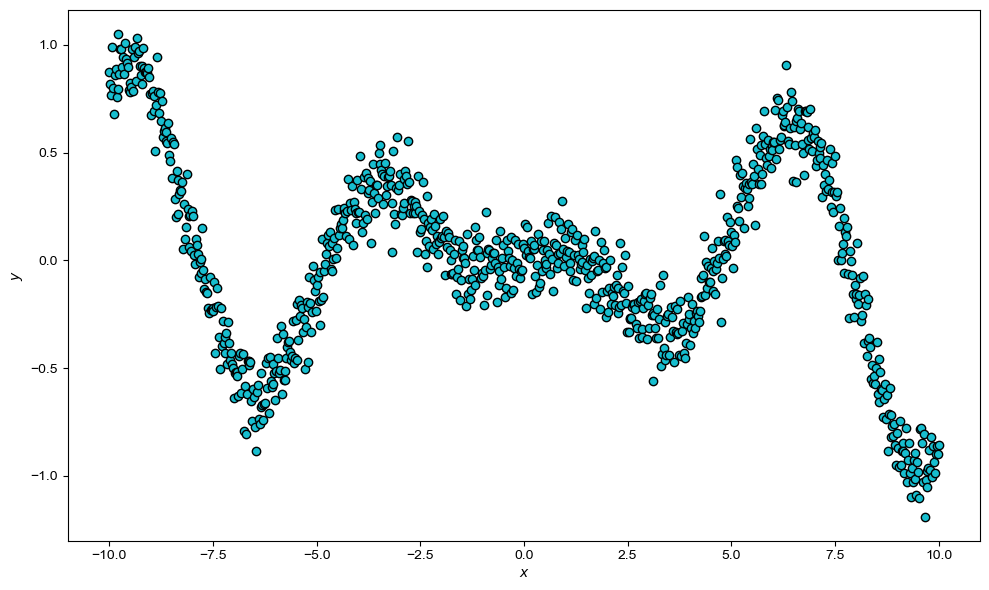

In [28]:
fig = plot_regression(X_train, Y_train)
# fig.savefig("regression-20_training_prototypes.png", dpi=600)

In [29]:
class RNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
    def forward(self, x):
        h = torch.zeros(self.num_layers, len(x), self.hidden_size)
        y, h = self.rnn(x)
        return y, h

In [30]:
rnn_regressor = RNNRegressor(input_size=X_train.shape[1], hidden_size=10, num_layers=1)

In [ ]:
# X = X_train
# Y = Y_train
O = torch.full_like(Y, float('nan'))
losses = []

for epoch in range(1):
    for i in range(len(X)):
        x = X[i:i+1]
        y = Y[i:i+1]

        rnn_regressor.train()
        optimizer.zero_grad()
        o, h = rnn_regressor(x)
        
        loss = criterion(o, y)
        optimizer.step()
        losses.append(loss.detach())
print("-" * 30)

In [ ]:
fig, ax = plt.subplots(figsize=)
ax.plot(losses)

In [ ]:
y = np.sin(np.linspace(0,100,1000)+2*np.pi*np.random.rand())
X = torch.autograd.Variable(torch.Tensor(y))[:100].view(-1,1,1)

In [ ]:
X.shape, y.shape